## GBDT

### GBDT 回归

In [2]:
import numpy as np


# 获取 训练数据

dataset = np.array(
               [[1, 5, 20, 1.1],
                [2, 7, 30, 1.3],
                [3, 21, 70, 1.7],
                [4, 30, 60, 1.8],
               ])
columns=['id', 'age', 'weight', 'label']


X = dataset[:,0:3]
y = dataset[:,3]

np.mean(y)


1.475

In [4]:
import numpy as np 

In [2]:

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
 
 
# 加载sklearn自带的波士顿房价数据集
dataset = load_boston()
 
# 提取特征数据和目标数据
X = dataset.data
y = dataset.target
 
# 将数据集以9:1的比例随机分为训练集和测试集，为了重现随机分配设置随机种子，即random_state参数
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1, random_state=188)
 
# 实例化估计器对象
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = ensemble.GradientBoostingRegressor(**params)
 
# 估计器拟合训练数据
gbr.fit(X_train, y_train)
 
# 训练完的估计器对测试数据进行预测
y_pred = gbr.predict(X_test)
 
# 输出特征重要性列表
print(gbr.feature_importances_)
print(mean_squared_error(y_test, y_pred))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

[2.10468489e-02 2.19685381e-04 3.18321729e-03 4.38178482e-06
 2.67054679e-02 4.31523248e-01 7.36599365e-03 7.77718381e-02
 1.61097210e-03 1.44386410e-02 3.05379296e-02 1.13717273e-02
 3.74220049e-01]
8.36033078629097


In [5]:
np.shape(X)

(506, 13)

In [10]:
def sigmoid(  X):
    """
    sigmoid 激活函数
    :param X:
    :return:
    """
    return 1 / (1 + np.exp(-X))

sigmoid(float('-inf'))

0.0

### GBDT 二分类

In [1]:
import numpy as np

import time

from sklearn.ensemble import GradientBoostingClassifier

from sklearn import datasets

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import ensemble


import sys

sys.path.append('E:\\python package\\python-project\\统计学习方法\\Statistical-Learning-Method_Code-master\\DecisionTree')

from CartTree_regression_xrh import *



In [16]:
class GDBT_2Classifier:
    """

    适用于 二分类 问题 的 梯度提升树

    基分类器为 CART 回归树

    Author: xrh
    Date: 2021-04-10

    ref: https://zhuanlan.zhihu.com/p/89549390


    test1: 二分类任务

    数据集：Mnist
    参数: error_rate_threshold=0.01, max_iter=30, max_depth=3,learning_rate=0.2

    训练集数量：60000
    测试集数量：10000
    正确率： 0.9891
    模型训练时长：205.7052161693573

    """

    def __init__(self, error_rate_threshold=0.05, max_iter=10, max_depth=1):
        """

        :param error_rate_threshold: 训练中止条件, 若当前得到的基分类器的组合 的错误率 小于阈值, 则停止训练
        :param max_iter: 最大迭代次数
        :param max_depth: CART 回归树 的最大深度
        """

        # 训练中止条件 error_rate  < self.error_rate_threshold ( 若当前得到的基分类器的组合 的错误率 小于阈值, 则停止训练)
        self.error_rate_threshold = error_rate_threshold

        # 最大迭代次数
        self.max_iter = max_iter

        # CART 回归树 的最大深度
        self.max_depth = max_depth

        self.G = []  # 弱分类器 集合

    def sigmoid( self , X ):
        """
        sigmoid 激活函数
        :param X:
        :return:
        """
        return 1 / (1 + np.exp(-X))

    def fit(self, X, y, learning_rate):
        """

        用 训练数据 拟合模型

        :param X: 特征数据 , shape=(N_sample, N_feature)
        :param y: 标签数据 , shape=(N_sample,)
        :param learning_rate: 学习率
        :return:
        """


        N = np.shape(X)[0]  # 样本的个数

        f = 0  # 基分类器 的加权和

        P_1 = len(y[y == 1]) / len(y)
        y_predict = np.log(P_1 / (1 - P_1))

        self.G.append(y_predict)

        f += y_predict

        feature_value_set = RegresionTree.get_feature_value_set(X)  # 可供选择的特征集合 , 包括 (特征, 切分值)

        for m in range(self.max_iter):  # 进行 第 m 轮迭代

            r = y - self.sigmoid(f)  # 残差

            RT = RegresionTree_GBDT(min_square_loss=0.1, max_depth=self.max_depth,print_log=False)

            RT.fit(X, r, y, feature_value_set=feature_value_set)

            y_predict = RT.predict(X)

            self.G.append((learning_rate, RT))  # 存储 基分类器

            # 计算 当前 所有弱分类器加权 得到的 最终分类器 的 分类错误率

            f += learning_rate * y_predict

            G = self.sigmoid(f)

            #TODO: 负例 设置为 -1 会导致 在训练集的 训练误差率无法下降, 原因未知

            G[G >= 0.5] = 1  # 概率 大于 0.5 被标记为 正例
            G[G < 0.5] = 0  # 概率 小于 0.5 被标记为 负例

            err_arr = np.ones(N, dtype=int)
            err_arr[G == y] = 0
            err_rate = np.mean(err_arr)

            print('round:{}, err_rate:{}'.format(m, err_rate))
            print('======================')

            if err_rate < self.error_rate_threshold:  # 错误率 已经小于 阈值, 则停止训练
                break

    def predict(self, X):
        """
        对 测试 数据进行预测, 返回预测的标签

        :param X: 特征数据 , shape=(N_sample, N_feature)
        :return:
        """

        f = 0  # 最终分类器

        f += self.G[0]  # 第一个 存储的是 初始化情况

        for alpha, RT in self.G[1:]:
            y_predict = RT.predict(X)
            f += alpha * y_predict

        # print('f:',f)

        G = self.sigmoid(f)

        # print('G:',G)

        G[G >= 0.5] = 1  # 概率 大于 0.5 被标记为 正例
        G[G < 0.5] = 0  # 概率 小于 0.5 被标记为 负例

        return G

    def predict_proba(self, X):
        """
        对 测试 数据进行预测, 返回预测的 概率值

        :param X: 特征数据 , shape=(N_sample, N_feature)
        :return:
        """

        f = 0  # 最终分类器

        f += self.G[0]  # 第一个 存储的是 初始化情况

        for alpha, RT in self.G[1:]:
            y_predict = RT.predict(X)
            f += alpha * y_predict

        # print('f:',f)
        G = self.sigmoid(f)

        return G


    def score(self, X, y):
        """
        使用 测试数据集 对模型进行评价, 返回正确率

        :param X: 特征数据 , shape=(N_sample, N_feature)
        :param y: 标签数据 , shape=(N_sample,)
        :return:  正确率 accuracy
        """

        N = np.shape(X)[0]  # 样本的个数

        G = self.predict(X)

        err_arr = np.ones(N, dtype=int)
        err_arr[G == y] = 0
        err_rate = np.mean(err_arr)

        accuracy = 1 - err_rate

        return accuracy

In [17]:

def loadData_2classification( fileName, n=1000):
    '''
    加载文件

    将 数据集 的标签 转换为 二分类的标签

    :param fileName:要加载的文件路径
    :param n: 返回的数据集的规模
    :return: 数据集和标签集
    '''
    # 存放数据及标记
    dataArr = []
    labelArr = []
    # 读取文件
    fr = open(fileName)

    cnt = 0  # 计数器

    # 遍历文件中的每一行
    for line in fr.readlines():

        if cnt == n:
            break

        # 获取当前行，并按“，”切割成字段放入列表中
        # strip：去掉每行字符串首尾指定的字符（默认空格或换行符）
        # split：按照指定的字符将字符串切割成每个字段，返回列表形式
        curLine = line.strip().split(',')
        # 将每行中除标记外的数据放入数据集中（curLine[0]为标记信息）
        # 在放入的同时将原先字符串形式的数据转换为整型
        # 此外将数据进行了二值化处理，大于128的转换成1，小于的转换成0，方便后续计算
        dataArr.append([int(int(num) > 128) for num in curLine[1:]])

        # 将标记信息放入标记集中
        # 转换成二分类任务
        # 标签0设置为1，反之为0

        # 显然这会导致 正负 样本的 分布不均衡, 1 的样本很少(10%), 而0 的很多
        if int(curLine[0]) == 0:
            labelArr.append(1)
        else:
            labelArr.append(0)

        # if int(curLine[0]) <= 5:
        #     labelArr.append(1)
        # else:
        #     labelArr.append(0)

        cnt += 1

    fr.close()

    # 返回数据集和标记
    return dataArr, labelArr
    
    

In [4]:
n_train=6000

# 获取训练集
trainDataList, trainLabelList =loadData_2classification('../Mnist/mnist_train.csv', n=n_train)

print('train data, row num:{} , column num:{} '.format(len(trainDataList), len(trainDataList[0])))

trainDataArr = np.array(trainDataList)
trainLabelArr = np.array(trainLabelList)


train data, row num:6000 , column num:784 


In [18]:

# 开始时间
print('start training model....')
start = time.time()



clf = GDBT_2Classifier( error_rate_threshold=0.01, max_iter=30, max_depth=3 )
clf.fit(trainDataArr, trainLabelArr,learning_rate=0.2)


# 结束时间
end = time.time()
print('training cost time :', end - start)




start training model....


E:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
E:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


round:0, err_rate:0.09866666666666667
round:1, err_rate:0.053
round:2, err_rate:0.05
round:3, err_rate:0.04783333333333333
round:4, err_rate:0.037
round:5, err_rate:0.0345
round:6, err_rate:0.028166666666666666
round:7, err_rate:0.025166666666666667
round:8, err_rate:0.0235
round:9, err_rate:0.0205
round:10, err_rate:0.018166666666666668
round:11, err_rate:0.017
round:12, err_rate:0.01633333333333333
round:13, err_rate:0.013833333333333333
round:14, err_rate:0.013
round:15, err_rate:0.011833333333333333
round:16, err_rate:0.011166666666666667
round:17, err_rate:0.011
round:18, err_rate:0.009666666666666667
training cost time : 19.053876638412476


In [40]:

clf2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=30
                                  , max_depth=3
                                )
clf2.fit(trainDataArr, trainLabelArr)



GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
n_test=1000

# 获取测试集
testDataList, testLabelList = loadData_2classification('../Mnist/mnist_test.csv', n=n_test)

print('test data, row num:{} , column num:{} '.format(len(testDataList), len(testDataList[0])))

testDataArr = np.array(testDataList)
testLabelArr = np.array(testLabelList)

print('test dataset accuracy: {} '.format(clf.score(testDataArr, testLabelArr)))

test data, row num:1000 , column num:784 
test dataset accuracy: 0.974 


#### 模型评估 

In [20]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score

from sklearn.metrics import recall_score

from sklearn.metrics import f1_score


y_pred= clf.predict(testDataArr)
y_true=testLabelArr


# 1.正确率
print('test dataset accuracy: {} '.format(accuracy_score(y_true, y_pred)))

print('====================')

# 2.精确率  

# print(precision_score(y_true, y_pred, average='macro'))  # 
# print(precision_score(y_true, y_pred, average='micro'))  # 
# print(precision_score(y_true, y_pred, average='weighted'))  # 

print('pos-1 precision: ',precision_score(y_true, y_pred, average='binary')) 

precision_list= precision_score(y_true, y_pred, average=None)

print('neg-0 precision:{}, pos-1 precision:{}  '.format(precision_list[0],precision_list[1]) ) 

print('====================')

# 3. 召回率

# print(recall_score(y_true, y_pred, average='macro'))  # 
# print(recall_score(y_true, y_pred, average='micro'))  # 
# print(recall_score(y_true, y_pred, average='weighted'))  # 

print('pos-1 recall: ',recall_score(y_true, y_pred, average='binary')) 

recall_list= recall_score(y_true, y_pred, average=None)

print('neg-0 recall:{}, pos-1 recall:{}  '.format(recall_list[0],recall_list[1]) )

print('====================')

# 4. F1-score

# print(f1_score(y_true, y_pred, average='macro'))  
# print(f1_score(y_true, y_pred, average='micro')) 
# print(f1_score(y_true, y_pred, average='weighted'))  

print('pos-1 f1_score: ',f1_score(y_true, y_pred, average='binary')) 

f1_score_list= f1_score(y_true, y_pred, average=None)

print('neg-0 f1_score:{}, pos-1 f1_score:{}  '.format(f1_score_list[0],f1_score_list[1]) )

print('====================')



test dataset accuracy: 0.974 
pos-1 precision:  0.8641975308641975
neg-0 precision:0.9836779107725789, pos-1 precision:0.8641975308641975  
pos-1 recall:  0.8235294117647058
neg-0 recall:0.9879781420765027, pos-1 recall:0.8235294117647058  
pos-1 f1_score:  0.8433734939759034
neg-0 f1_score:0.9858233369683752, pos-1 f1_score:0.8433734939759034  


In [48]:
y_scores2= clf2.predict_proba(testDataArr)[:,0]
# y_scores2

precision2, recall2, thresholds2 = precision_recall_curve(y_true, y_scores2)

##### P-R 曲线

Text(0.5, 1.0, ' Precision-Recall curve ')

Text(0.5, 0, 'recall')

Text(0, 0.5, 'precision')

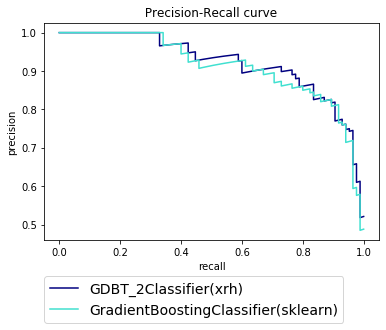

In [68]:
# 画出 P-R 曲线

from itertools import cycle

# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# from sklearn.metrics import PrecisionRecallDisplay


y_pred= clf.predict(testDataArr)

y_scores= clf.predict_proba(testDataArr)

y_true=testLabelArr



precision, recall, thresholds = precision_recall_curve(y_true, y_scores)


y_scores2= clf2.predict_proba(testDataArr)[:,1]  # 第 1 列 , 表示为 正例的概率

precision2, recall2, thresholds2 = precision_recall_curve(y_true, y_scores2)



# disp = PrecisionRecallDisplay(precision=precision, recall=recall)
# disp.plot() 


plt.plot(recall, precision, label="GDBT_2Classifier(xrh)",color='navy' ) # 

plt.plot(recall2, precision2, label="GradientBoostingClassifier(sklearn)",color='turquoise' )


plt.title(' Precision-Recall curve ')

# plt.ylim([0.0, 1.05]) # Y 轴的取值范围
# plt.xlim([0.0, 1.0]) # X 轴的取值范围



plt.xlabel("recall")
plt.ylabel("precision")

plt.legend( loc=(0, -.38), prop=dict(size=14) ) # 图例

plt.show()



**P-R 关系图的 左右端点的讨论**

In [67]:
ratio_pos= len(y_true[y_true==1]) / len(y_true)
ratio_pos

0.085

In [63]:
# 左端点
recall2[-1], precision2[-1],thresholds2[-1]

(0.0, 1.0, 0.9645801956834433)

In [64]:
# 右端点
recall2[0], precision2[0],thresholds2[0]

(1.0, 0.4885057471264368, 0.03735027619099542)

##### ROC 曲线

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

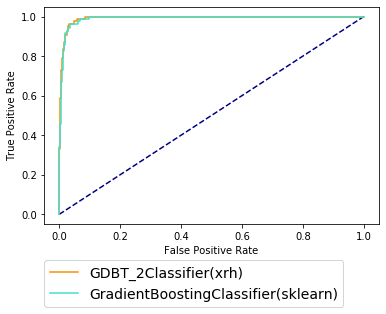

In [76]:
from sklearn.metrics import roc_curve


fpr, tpr, _ = roc_curve(y_true, y_scores)

fpr2, tpr2, _ = roc_curve(y_true, y_scores2)

plt.plot( [0, 1], [0, 1], color='navy', linestyle='--' )


plt.plot( fpr, tpr, label="GDBT_2Classifier(xrh)",color='darkorange' ) # 

plt.plot( fpr2, tpr2, label="GradientBoostingClassifier(sklearn)",color='turquoise' )

# plt.xlim( [0.0, 1.0] )
# plt.ylim( [0.0, 1.05] )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.legend( loc=(0, -.38), prop=dict(size=14) ) # 图例

plt.show()

**ROC 曲线的 左右端点的讨论**

In [81]:
# 右端点
fpr[-1], tpr[-1],thresholds[-1]

(1.0, 1.0, 0.9869376470477005)

In [80]:
# 左端点
fpr[0], fpr[0],thresholds2[0]

(0.0, 0.0, 0.03735027619099542)

### GBDT 多分类

In [143]:


X_train=[  [6],
           [12],
           [14],
           [18],
           [20],
           [65],
           [31],
           [40],
           [1],
           [2],
           [100],
           [101],
           [65],
           [54],
           ]

y_train= np.array([[0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [2], [2], [2], [2]]).ravel()

X=X_train

y=y_train

max_iter=5

N = np.shape(X)[0]  # 样本的个数



K = len({ele for ele in y})  # y 中有多少种不同的标签,  K分类

print('according to the training dataset : K={} classification task'.format(K))

F = np.zeros( (K , N),dtype=float) # shape: (K,N)

for k in range(K): # 遍历 所有的 类别

    F[k,:] = len(y[y == k]) / len(y)

    


according to the training dataset : K=3 classification task


In [142]:
def softmax(X):
    """
    softmax处理，将结果转化为概率

    :param X:
    :return:
    """
    return np.e ** X / ((np.e ** X).sum(axis=0))  # softmax处理，将结果转化为概率


In [147]:
m=1

p = softmax( F )



y_one_hot = ( y == np.array(range(K)).reshape(-1, 1) ).astype(
    np.int8)  # 将 预测向量 扩展为 one-hot , shape: (K,N)

p_k=p[0]
y_one_hot_k = y_one_hot[0]

r=y_one_hot_k - p_k

r

array([ 0.65882682,  0.65882682,  0.65882682,  0.65882682,  0.65882682,
       -0.34117318, -0.34117318, -0.34117318, -0.34117318, -0.34117318,
       -0.34117318, -0.34117318, -0.34117318, -0.34117318])

In [151]:


F_0 = np.array( [1,2,3],dtype=float)  # shape : (K,)
    
np.transpose([F_0] * 3)

array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]])

In [152]:
np.exp(3085)

inf